In [93]:
# Import dependencies
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import scipy.stats as st

In [2]:
# Read into excel file
xls = pd.ExcelFile("./Resources/KPMG_VI_New_raw_data_update_final.xlsx")
transactions_xls = pd.read_excel(xls, "Transactions", header=1)
new_customer_list_xls = pd.read_excel(xls, "NewCustomerList", header=1)
customer_demographic_xls = pd.read_excel(xls, "CustomerDemographic", header=1)
customer_address_xls = pd.read_excel(xls, "CustomerAddress", header=1)

## Data Cleaning

In [3]:
# Create function to drop all customer_ids above 3500
def consistent_id(excel_sheet):
    excel_sheet = excel_sheet.loc[excel_sheet["customer_id"] <= 3500]
    return excel_sheet

In [4]:
# Apply range of below 3500 to all sheets
cleaned_transactions_xls = consistent_id(transactions_xls)
cleaned_customer_demographic_xls = consistent_id(customer_demographic_xls)
cleaned_customer_address_xls = consistent_id(customer_address_xls)

### Transactions

In [5]:
cleaned_transactions_xls.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [6]:
# Convert online order column to boolean
cleaned_transactions_xls["online_order"] = cleaned_transactions_xls["online_order"].astype(bool)

In [7]:
# Drop all null values for transactions
cleaned_transactions_xls = cleaned_transactions_xls.dropna()

In [8]:
# Display cleaned dataframe
cleaned_transactions_xls.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


### Customer Demographics

In [9]:
# Drop null values only for DOB and job title columns of customer demographics
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls.dropna(subset=["DOB", "job_title"])

In [10]:
# Drop default column of meta data
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls.drop(columns="default")

In [11]:
# Check remaining null values
# Remain nulls for last_name and job_industry_category as they do not affect future analysis
cleaned_customer_demographic_xls.count()

customer_id                            3004
first_name                             3004
last_name                              2908
gender                                 3004
past_3_years_bike_related_purchases    3004
DOB                                    3004
job_title                              3004
job_industry_category                  2531
wealth_segment                         3004
deceased_indicator                     3004
owns_car                               3004
tenure                                 3004
dtype: int64

In [12]:
# Find outlier of DOB column
cleaned_customer_demographic_xls["DOB"].min()

Timestamp('1843-12-21 00:00:00')

In [13]:
# Drop outlier
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls[cleaned_customer_demographic_xls.DOB != "1843-12-21 00:00:00"]

In [14]:
# Add age column
now = pd.Timestamp("now")
cleaned_customer_demographic_xls["age"] = (now - cleaned_customer_demographic_xls["DOB"]).astype("<m8[Y]")

In [15]:
# Create age bins for analysis later
cleaned_customer_demographic_xls["age_bins"] = pd.cut(x=cleaned_customer_demographic_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89])

In [16]:
cleaned_customer_demographic_xls["age_bins"].unique()

[(59, 69], (29, 39], (39, 49], (49, 59], (19, 29], (10, 19], (69, 79], (79, 89]]
Categories (8, interval[int64]): [(10, 19] < (19, 29] < (29, 39] < (39, 49] < (49, 59] < (59, 69] < (69, 79] < (79, 89]]

In [17]:
cleaned_customer_demographic_xls["age_by_decade"] = pd.cut(x=cleaned_customer_demographic_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89], labels=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s"])

In [18]:
# Check for gender unique values
cleaned_customer_demographic_xls["gender"].value_counts()

Female    1532
Male      1468
F            1
M            1
Femal        1
Name: gender, dtype: int64

In [19]:
# Replace inconsistent values in gender column
cleaned_customer_demographic_xls["gender"] = cleaned_customer_demographic_xls["gender"].replace(["Femal", "F", "M"], ["Female", "Female", "Male"])

In [20]:
# List all available columns
cd_cols = list(cleaned_customer_demographic_xls.columns.values)
cd_cols

['customer_id',
 'first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure',
 'age',
 'age_bins',
 'age_by_decade']

In [21]:
# Rearrange columns
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls
[['customer_id',
 'first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'age',
 'age_bins',
 'age_by_decade',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure']]

[['customer_id',
  'first_name',
  'last_name',
  'gender',
  'past_3_years_bike_related_purchases',
  'DOB',
  'age',
  'age_bins',
  'age_by_decade',
  'job_title',
  'job_industry_category',
  'wealth_segment',
  'deceased_indicator',
  'owns_car',
  'tenure']]

In [22]:
# Display cleaned dataframe
cleaned_customer_demographic_xls.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,age,age_bins,age_by_decade
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,67.0,"(59, 69]",60s
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,39.0,"(29, 39]",30s
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,66.0,"(59, 69]",60s
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,43.0,"(39, 49]",40s
7,8,Rod,Inder,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,No,7.0,58.0,"(49, 59]",50s


### Customer Address

In [23]:
# Check for null values
cleaned_customer_address_xls.count()

customer_id           3496
address               3496
postcode              3496
state                 3496
country               3496
property_valuation    3496
dtype: int64

In [24]:
# Check for values that need to be replaced
cleaned_customer_address_xls["state"].value_counts()

NSW                1783
VIC                 801
QLD                 744
New South Wales      86
Victoria             82
Name: state, dtype: int64

In [25]:
# Replace inconsistent values in state column
cleaned_customer_address_xls["state"] = cleaned_customer_address_xls["state"].replace(["New South Wales", "Victoria"], ["NSW", "VIC"])

In [26]:
# Check if values were successfully replaced
cleaned_customer_address_xls["state"].value_counts()

NSW    1869
VIC     883
QLD     744
Name: state, dtype: int64

In [27]:
# Display cleaned dataframe
cleaned_customer_address_xls.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,NSW,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


### New customer list

In [28]:
# Add age column to new customers list
new_customer_list_xls["age"] = (now - new_customer_list_xls["DOB"]).astype("<m8[Y]")

In [29]:
# Create age bins for analysis later
new_customer_list_xls["age_bins"] = pd.cut(x=new_customer_list_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89])

In [30]:
# Create age bins labels
new_customer_list_xls["age_by_decade"] = pd.cut(x=new_customer_list_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89], labels=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s"])

In [31]:
# List all available columns in dataframe
cl_cols = list(new_customer_list_xls.columns.values)
cl_cols

['first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure',
 'address',
 'postcode',
 'state',
 'country',
 'property_valuation',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19',
 'Unnamed: 20',
 'Rank',
 'Value',
 'age',
 'age_bins',
 'age_by_decade']

In [32]:
# Rearrange columns
new_customer_list_xls = new_customer_list_xls[['first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'age',
 'age_bins',
 'age_by_decade',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure',
 'address',
 'postcode',
 'state',
 'country',
 'property_valuation',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19',
 'Unnamed: 20',
 'Rank',
 'Value']]

In [33]:
# Display final dataframe
new_customer_list_xls.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,age,age_bins,age_by_decade,job_title,job_industry_category,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,63.0,"(59, 69]",60s,General Manager,Manufacturing,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,50.0,"(49, 59]",50s,Structural Engineer,Property,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,46.0,"(39, 49]",40s,Senior Cost Accountant,Financial Services,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,41.0,"(39, 49]",40s,Account Representative III,Manufacturing,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,55.0,"(49, 59]",50s,Financial Analyst,Financial Services,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


## Exploratory Data Analysis

In [34]:
# Merge customer demographics and transactions dataframes
merged_transactions_demographics = pd.merge(cleaned_customer_demographic_xls, cleaned_transactions_xls, on="customer_id", how="inner")
merged_transactions_demographics

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-12-23,False,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38482.0
1,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-04-06,True,Approved,Solex,Standard,medium,medium,1577.53,826.51,39526.0
2,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-05-11,True,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
3,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-01-05,False,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,37873.0
4,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-02-21,False,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17023,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,N,...,2017-03-07,False,Approved,Trek Bicycles,Mountain,low,medium,574.64,459.71,37659.0
17024,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,N,...,2017-04-02,True,Approved,Norco Bicycles,Standard,high,small,1661.92,1479.11,40303.0
17025,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,N,...,2017-11-08,True,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,42688.0
17026,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,N,...,2017-09-01,True,Approved,Solex,Standard,medium,medium,575.27,431.45,35160.0


In [35]:
merged_transactions_demographics.count()

customer_id                            17028
first_name                             17028
last_name                              16490
gender                                 17028
past_3_years_bike_related_purchases    17028
DOB                                    17028
job_title                              17028
job_industry_category                  14315
wealth_segment                         17028
deceased_indicator                     17028
owns_car                               17028
tenure                                 17028
age                                    17028
age_bins                               17028
age_by_decade                          17028
transaction_id                         17028
product_id                             17028
transaction_date                       17028
online_order                           17028
order_status                           17028
brand                                  17028
product_line                           17028
product_cl

In [36]:
# Merge customer address and transactions dataframes
merged_transactions_address = pd.merge(cleaned_customer_address_xls, merged_transactions_demographics, on="customer_id", how="inner")
merged_transactions_address

,customer_id,address,postcode,state,country,property_valuation,first_name,last_name,gender,past_3_years_bike_related_purchases,...,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-12-23,False,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38482.0
1,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-04-06,True,Approved,Solex,Standard,medium,medium,1577.53,826.51,39526.0
2,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-05-11,True,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
3,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-01-05,False,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,37873.0
4,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-02-21,False,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17010,3496,2565 Caliangt Point,2171,NSW,Australia,9,Danya,Burnyeat,Male,99,...,2017-03-07,False,Approved,Trek Bicycles,Mountain,low,medium,574.64,459.71,37659.0
17011,3496,2565 Caliangt Point,2171,NSW,Australia,9,Danya,Burnyeat,Male,99,...,2017-04-02,True,Approved,Norco Bicycles,Standard,high,small,1661.92,1479.11,40303.0
17012,3497,96 Delladonna Trail,3976,VIC,Australia,5,Thia,O'Day,Female,73,...,2017-11-08,True,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,42688.0
17013,3497,96 Delladonna Trail,3976,VIC,Australia,5,Thia,O'Day,Female,73,...,2017-09-01,True,Approved,Solex,Standard,medium,medium,575.27,431.45,35160.0


In [37]:
merged_transactions_address.count()

customer_id                            17015
address                                17015
postcode                               17015
state                                  17015
country                                17015
property_valuation                     17015
first_name                             17015
last_name                              16477
gender                                 17015
past_3_years_bike_related_purchases    17015
DOB                                    17015
job_title                              17015
job_industry_category                  14302
wealth_segment                         17015
deceased_indicator                     17015
owns_car                               17015
tenure                                 17015
age                                    17015
age_bins                               17015
age_by_decade                          17015
transaction_id                         17015
product_id                             17015
transactio

## Customer Segmentation Analysis
### Finding potential relationships between variables - use Seaborn heatmap
### Exploring demographic, geographic, behavioural, psychographic data

age vs past 3 years bike related purchases

gender vs past 3 years bike related purchases

state vs cars owned - bar chart

wealth segment by age  - stacked bar chart

state vs owns cars - grouped bar chart

In [38]:
# Use seaborn styling for charts
plt.style.use("seaborn")

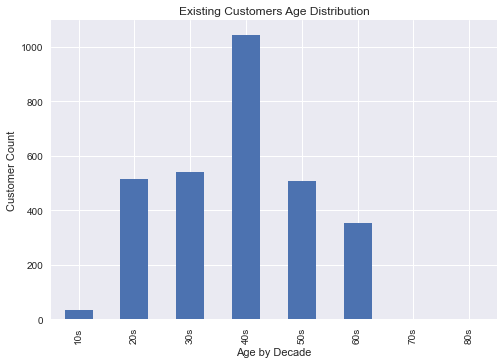

In [39]:
# Existing customers age distribution
grouped_age = merged_transactions_demographics.groupby(["age_by_decade"])
people_count = grouped_age["customer_id"].nunique()
people_count.plot.bar()
plt.style.use("seaborn")
plt.title("Existing Customers Age Distribution")
plt.xlabel("Age by Decade")
plt.ylabel("Customer Count")
plt.savefig("output/existing_customers_age_distribution.png")

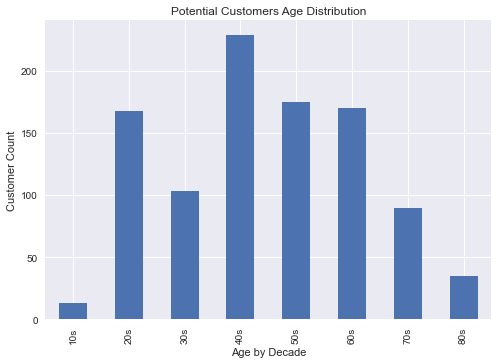

In [40]:
# Potential customers age distribution
grouped_age = new_customer_list_xls.groupby(["age_by_decade"])
people_count = grouped_age["first_name"].count()
people_count.plot.bar()
plt.title("Potential Customers Age Distribution")
plt.xlabel("Age by Decade")
plt.ylabel("Customer Count")
plt.savefig("output/potential_customers_age_distribution.png")

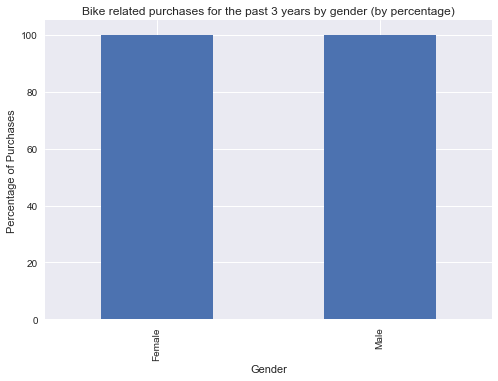

In [42]:
# Bike related purchases for the past 3 years by gender (existing customers)
three_years_transactions_percentage = (three_years_transactions_count/three_years_transactions_count * 100)
three_years_transactions_percentage.plot.bar(title="Bike related purchases for the past 3 years by gender (by percentage)")
plt.xlabel("Gender")
plt.ylabel("Percentage of Purchases")
plt.savefig("output/bike_related_purchases_last_3_years_by_genderr.png")

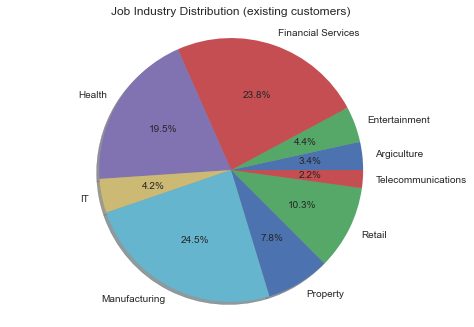

In [43]:
# Job Industry Distribution
grouped_job_categories = merged_transactions_address.groupby(["job_industry_category"])
job_category_count = grouped_job_categories["customer_id"].count()
job_category_count.plot.pie(title="Job Industry Distribution (existing customers)", autopct='%1.1f%%', shadow=True)
plt.ylabel("")
plt.axis("equal")
plt.savefig("output/job_industry_distribution_existing_customers.png")

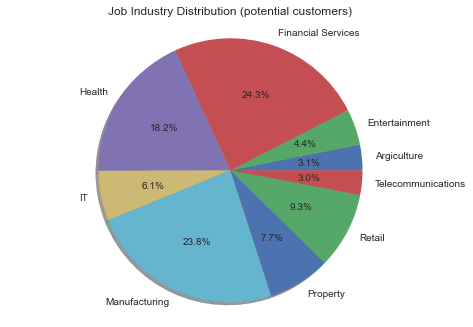

In [44]:
# Job Industry Distribution
grouped_job_categories = new_customer_list_xls.groupby(["job_industry_category"])
job_category_count = grouped_job_categories["first_name"].count()
job_category_count.plot.pie(title="Job Industry Distribution (potential customers)", autopct='%1.1f%%', shadow=True)
plt.ylabel("")
plt.axis("equal")
plt.savefig("output/job_industry_distribution_potential_customers.png")

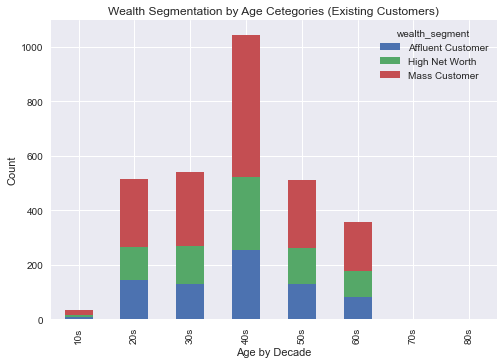

In [45]:
# Wealth segmentation by age category - stacked bar chart (existing customers)
grouped_age = cleaned_customer_demographic_xls.groupby(["age_by_decade"])
wealth_segment = grouped_age["wealth_segment"].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title("Wealth Segmentation by Age Cetegories (Existing Customers)")
plt.xlabel("Age by Decade")
plt.ylabel("Count")
plt.savefig("output/wealth_segmentation_by_age_existing_customers.png")

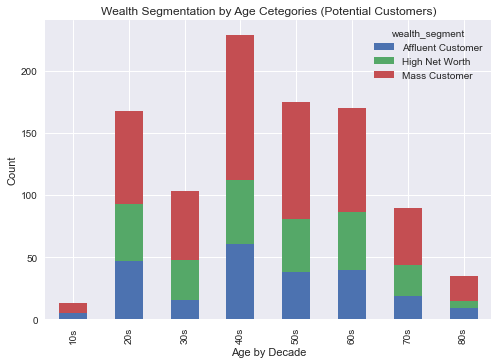

In [46]:
# Wealth segmentation by age category - stacked bar chart (potential customers)
grouped_age = new_customer_list_xls.groupby(["age_by_decade"])
wealth_segment = grouped_age["wealth_segment"].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title("Wealth Segmentation by Age Cetegories (Potential Customers)")
plt.xlabel("Age by Decade")
plt.ylabel("Count")
plt.savefig("output/wealth_segmentation_by_age_potential_customers.png")

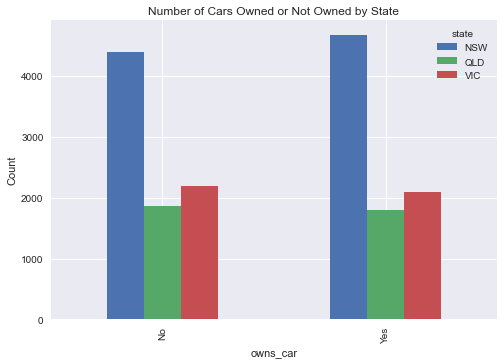

In [52]:
# Number of cars owned or not owned by state - grouped bar chart
merged_transactions_address.groupby("state").owns_car.value_counts().unstack(0).plot.bar()
plt.title("Number of Cars Owned or Not Owned by State")
plt.ylabel("Count")
plt.savefig("output/number_of_cars_owned_or_not_owned_by_state.png")

## Model Development
### Customer Segmentation using RFM analysis
Steps of RFM(Recency, Frequency, Monetary):

1. Calculate the Recency, Frequency, Monetary values for each Customer

2. Add segment bin values to RFM table using quartile

3. Sort the customer RFM score in ascending order

Correlation

In [53]:
cleaned_transactions_xls.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [54]:
# Define present date
latest_date = cleaned_transactions_xls["transaction_date"].max()
print(latest_date)

present = dt.datetime(2017,12,30)
present

2017-12-30 00:00:00


datetime.datetime(2017, 12, 30, 0, 0)

In [55]:
# Calculate Recency, Frequency and Monetary
rfm = cleaned_transactions_xls.groupby("customer_id").agg({"transaction_date": lambda date: (present - date.max()).days, 
                                                            "transaction_id": lambda num: len(num),
                                                            "list_price": lambda price: price.sum()})
rfm.columns

Index(['transaction_date', 'transaction_id', 'list_price'], dtype='object')

In [56]:
# Change column names
rfm.columns=["recency","frequency","monetary"]
rfm["recency"] = rfm["recency"].astype(int)
rfm.head()

,recency,frequency,monetary
customer_id,,,
1,7,11,9084.45
2,128,3,4149.07
3,102,8,9888.23
4,195,2,1047.72
5,16,6,5903.20


### Computing Quantile of RFM values
Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [57]:
# Using qcut() to bin data based on sample quantiles
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['4','3','2','1'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['1','2','3','4'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['1','2','3','4'])
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
customer_id,,,,,,
1,7,11,9084.45,4,4,4
2,128,3,4149.07,1,1,1
3,102,8,9888.23,1,4,4
4,195,2,1047.72,1,1,1
5,16,6,5903.20,4,2,2


### RFM Result Interpretation
Combine all three quartiles(r_quartile,f_quartile,m_quartile) in a single column, this rank will help to segment the customers well group.

In [158]:
rfm["RFM_Score"] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
1,7,11,9084.45,4,4,4,444
2,128,3,4149.07,1,1,1,111
3,102,8,9888.23,1,4,4,144
4,195,2,1047.72,1,1,1,111
5,16,6,5903.20,4,2,2,422
...,...,...,...,...,...,...,...
3496,256,4,4725.38,1,1,2,112
3497,52,3,3744.07,2,1,1,211
3498,127,6,5177.06,1,2,2,122


In [59]:
# Filter out Top/Best customers
rfm[rfm["RFM_Score"]=="444"].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
2183,8,14,19071.32,4,4,4,444
1140,6,13,16199.24,4,4,4,444
729,1,10,15826.00,4,4,4,444
1317,10,9,15370.81,4,4,4,444
1329,4,11,14818.12,4,4,4,444


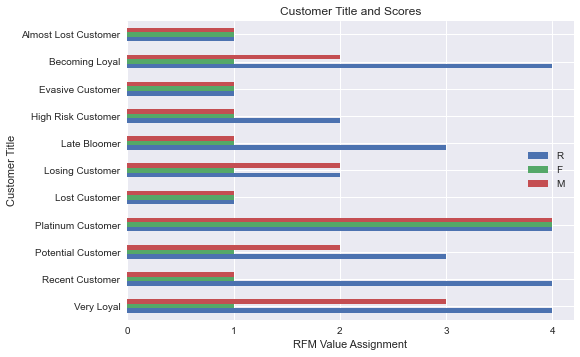

In [155]:
# Define customer titles and their respective rfm scores
customer_titles = dict([
    ("Very Loyal", [4, 1, 3]),
    ("Recent Customer", [4, 1, 1]),
    ("Potential Customer", [3, 1, 2]),
    ("Platinum Customer", [4, 4, 4]),
    ("Lost Customer", [1, 1, 1]),
    ("Losing Customer", [2, 1, 2]),
    ("Late Bloomer", [3, 1, 1]),
    ("High Risk Customer", [2, 1, 1]),
    ("Evasive Customer", [1, 1, 1]),
    ("Becoming Loyal", [4, 1, 2]),
    ("Almost Lost Customer", [1, 1, 1])
])

# Convert to dataframe
# .T transposes letter categories to the x-axis
customer_titles_df = pd.DataFrame(customer_titles).T

# Visualise
customer_titles_df.plot(kind="barh")
plt.title("Customer Title and Scores")
plt.xlabel("RFM Value Assignment")
plt.ylabel("Customer Title")
plt.legend(["R", "F", "M"])
xticks=[0, 1, 2, 3, 4]
plt.xticks(np.arange(5), xticks)
plt.savefig("output/customer_title_and_scores.png")

In [99]:
# Create a function to plot linear regression
def create_linear_regression_plot(x_values, y_values, x_label, y_label, line_placement, ylim=None):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    
    # Using pyplot to create scatter plot
    plt.scatter(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if ylim != None:
        plt.ylim = (0, ylim)
    plt.title(f'{x_label} vs. {y_label}')
    plt.annotate(line_eq,line_placement,fontsize=15,color="red")
    
    # Print r-squared value
    print(f"The r-squared is: {rvalue**2}")
    
    # Print correlation between both factors
    correlation = st.pearsonr(x_values,y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")

    # Tight layout
    plt.tight_layout()
    
    # Save linear regression plot as png file
    plt.savefig(f"output/{x_label}_vs_{y_label}.png")
    
    return plt.plot(x_values,regress_values,"r-")

The r-squared is: 0.10428799549112847
The correlation between both factors is -0.32


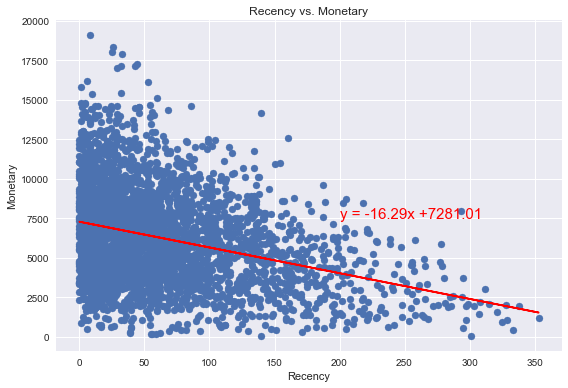

In [100]:
# Visualise recency vs monetary
x_values = rfm.recency
y_values = rfm.monetary

create_linear_regression_plot(x_values, y_values, "Recency", "Monetary", (200, 7500), ylim=None)

The r-squared is: 0.754365951232456
The correlation between both factors is 0.87


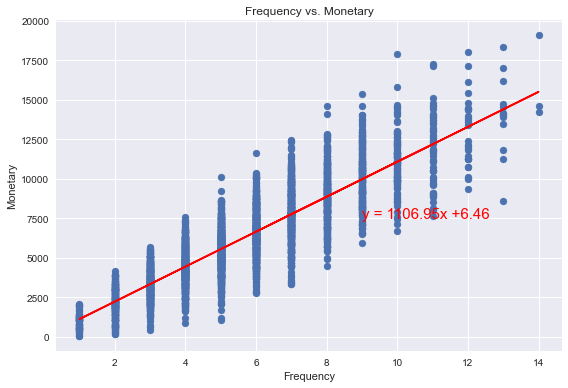

In [103]:
# Visualise frequency vs monetary
x_values = rfm.frequency
y_values = rfm.monetary

create_linear_regression_plot(x_values, y_values, "Frequency", "Monetary", (9, 7500), ylim=None)

The r-squared is: 0.1432063088537255
The correlation between both factors is -0.38


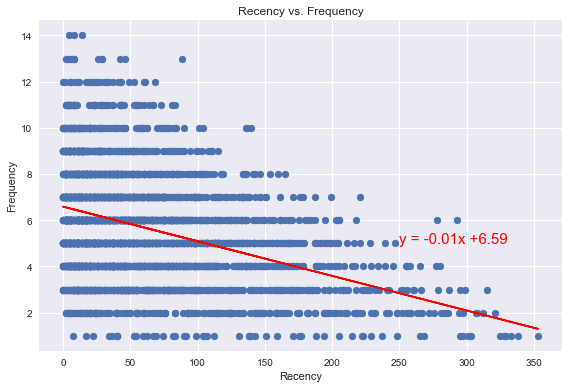

In [106]:
# Visualise recency vs monetary
x_values = rfm.recency
y_values = rfm.frequency

create_linear_regression_plot(x_values, y_values, "Recency", "Frequency", (250, 5), ylim=None)

In [182]:
reduced_rfm = rfm.loc[(rfm["RFM_Score"] == "444") | (rfm["RFM_Score"] == "443") | (rfm["RFM_Score"] == "434") | (rfm["RFM_Score"] == "433") | (rfm["RFM_Score"] == "411") | (rfm["RFM_Score"] == "344") | (rfm["RFM_Score"] == "343") | (rfm["RFM_Score"] == "334") | (rfm["RFM_Score"] == "333") | (rfm["RFM_Score"] == "212") | (rfm["RFM_Score"] == "124") | (rfm["RFM_Score"] == "112") | (rfm["RFM_Score"] == "111")]
reduced_rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
1,7,11,9084.45,4,4,4,444
2,128,3,4149.07,1,1,1,111
4,195,2,1047.72,1,1,1,111
7,253,3,995.38,1,1,1,111
8,22,10,12024.76,3,4,4,344
...,...,...,...,...,...,...,...
3489,108,6,8300.15,1,2,4,124
3491,189,4,3151.67,1,1,1,111
3493,93,6,10053.82,1,2,4,124


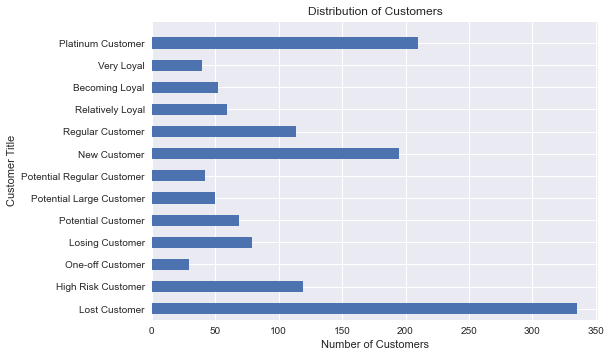

In [183]:
# Distribution of customers based on rfm
# Groupby rfm score
reduced_rfm.groupby("RFM_Score").RFM_Score.count().plot(kind="barh")
plt.title("Distribution of Customers")
plt.xlabel("Number of Customers")
plt.ylabel("Customer Title")
yticks = ["Lost Customer", "High Risk Customer", "One-off Customer", "Losing Customer", "Potential Customer", "Potential Large Customer", "Potential Regular Customer", "New Customer", "Regular Customer", "Relatively Loyal", "Becoming Loyal", "Very Loyal", "Platinum Customer"]
plt.yticks(np.arange(14), yticks)
plt.savefig("output/distribution_of_customers.png")